# Table of Contents

- [Libraries](#Libraries)
- [Data](#Data)
- [Multicolinearity](#Multicolinearity)
- [Modeling](#Modeling)
    - [K-Means](#K-Means)

# Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, k_means
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pitch_data = pd.read_csv('../datasets/mlb_pitch_stats_19_20_21.csv', index_col= ['player_id'])
pitch_data.drop(columns = ['Unnamed: 0',' first_name', 'last_name'], axis = 1, inplace = True)
print(pitch_data.shape)
pitch_data.head()

(1072, 86)


,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_brk,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,22.3,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,15.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,10.7,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570


# Multicolinearity

In [3]:
vif_data = pd.DataFrame()
vif_data["feature"] = pitch_data.columns

vif_data["VIF"] = [variance_inflation_factor(pitch_data.values, i)
                          for i in range(len(pitch_data.columns))]

vif_data.sort_values(by = 'VIF').head(5)

,feature,VIF
15,cg,1.364100
1,age,1.365355
81,cu_hb,1.527192
41,edge%,1.624982
29,solid_contact%,1.835575


In [4]:
X = pitch_data[['age', 'solid_contact%', 'poor_weak%', 
                'ch%', '4seam%', 'cu%', 'cb%', '4seam_vb', 
                'sl_brk', 'sl%', 'hard_hit%', 'ev_avg', 
                '4seam_brk', 'cb_brk', 'ch_brk', 'ch_spinrate', 
                '4seam_spinrate', '4seam_velo', 'la_avg', 'cu_brk']]
print(X.shape)
X.head()

(1072, 20)


,age,solid_contact%,poor_weak%,ch%,4seam%,cu%,cb%,4seam_vb,sl_brk,sl%,hard_hit%,ev_avg,4seam_brk,cb_brk,ch_brk,ch_spinrate,4seam_spinrate,4seam_velo,la_avg,cu_brk
player_id,,,,,,,,,,,,,,,,,,,,
425794,40,5.9,3.2,6.3,9.3,22.2,34.5,-19.6,0.0,0.0,35.9,88.3,15.1,22.3,16.1,1719.0,2229.0,89.1,10.1,9.5
425844,38,5.8,5.0,21.9,40.1,0.0,16.7,-18.0,8.9,15.5,34.3,88.1,16.7,15.6,13.7,1590.0,2236.0,89.0,10.9,0.0
429722,39,7.5,4.8,3.2,45.3,0.0,0.0,-17.2,5.4,51.5,43.5,89.8,15.0,0.0,15.7,1690.0,2179.0,93.4,13.3,0.0
433589,37,5.8,6.6,18.1,45.1,23.3,13.5,-17.7,0.0,0.0,29.9,86.4,18.7,10.7,18.8,1751.0,2135.0,87.6,20.3,17.3
445276,34,5.0,11.5,0.0,0.0,57.1,0.0,0.0,9.1,15.5,25.9,84.3,0.0,0.0,0.0,0.0,0.0,0.0,19.5,19.2


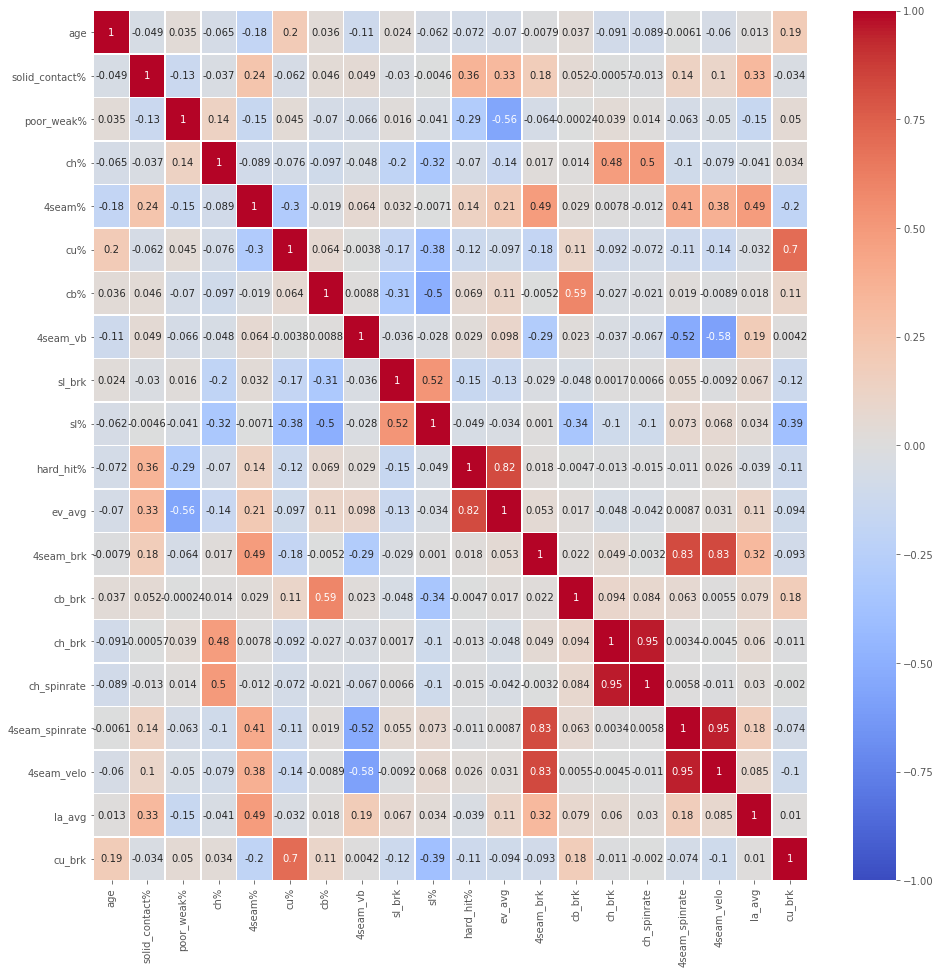

In [5]:
plt.figure(figsize = (16, 16))
sns.heatmap(X.corr(), annot = True, 
            vmin = -1, 
            vmax = 1,
            linewidths = 0.5,
            cmap = 'coolwarm');

# Modeling

### Standardize Data

In [6]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

X_scaled[:,:] *= -1

### PCA

In [7]:
pca = PCA().fit(X_scaled)
principalComponents = pca.transform(X_scaled)

[0.17822529 0.13029791 0.12770332 0.11571658 0.07539972 0.06815674
 0.05777235 0.04516131 0.04262078 0.0306251  0.02852539 0.02323971
 0.02030828 0.01686048 0.01495762 0.00899883 0.00604871 0.00570516
 0.00199274 0.00168398]


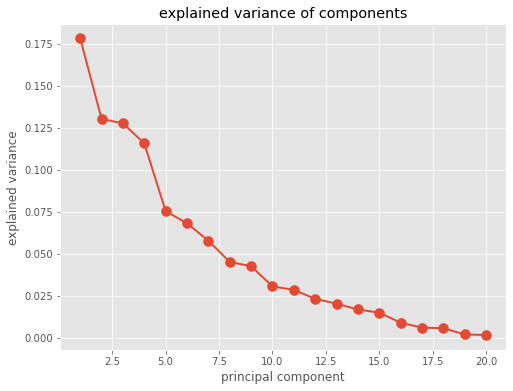

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,21), pca.explained_variance_ratio_, lw = 2)
ax.scatter(range(1, 21), pca.explained_variance_ratio_, s = 100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');
print(pca.explained_variance_ratio_)

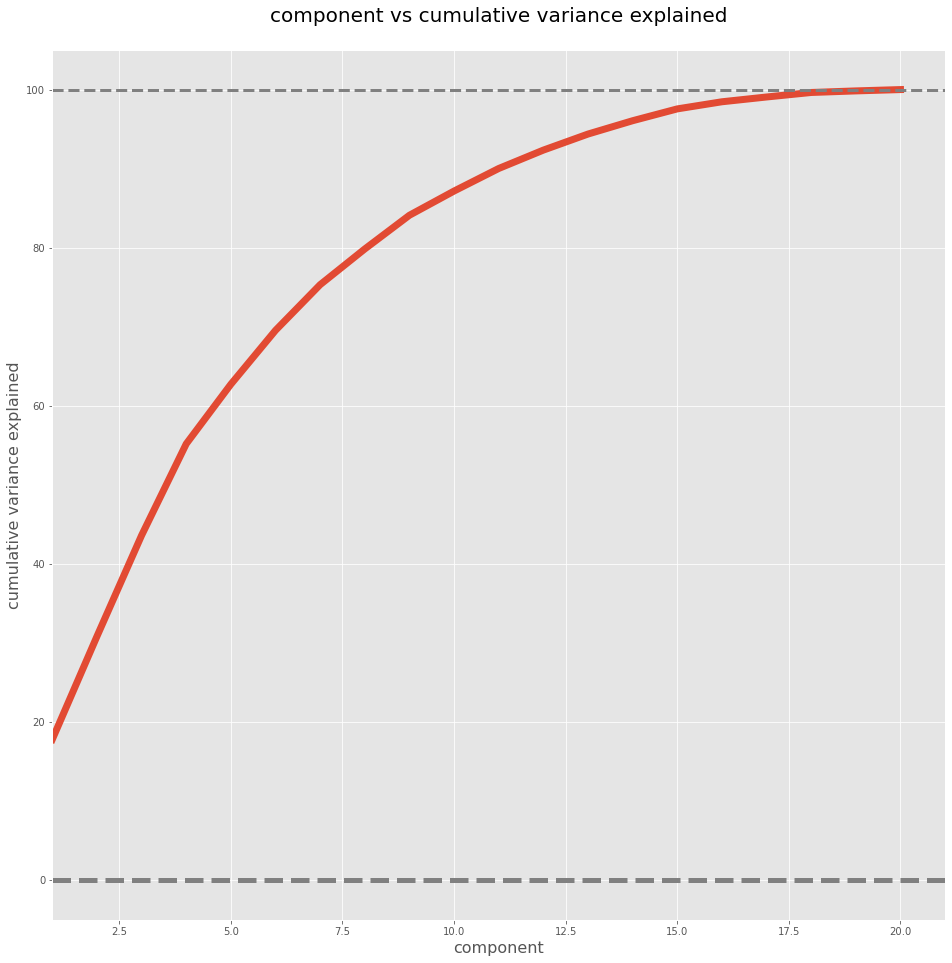

In [9]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(16,16))
component_number = range(1, 21)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,21], auto = True)
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20);

In [10]:
# this cell makes code for X break
#pca_component_1_eigenvec = pca.components_[0]

#for weight, X in zip(pca_component_1_eigenvec, 
#                     X.columns):
    
#    print(X, weight)

In [11]:
pitch_df = pd.DataFrame(data = principalComponents, 
                        columns = X.columns)

print(pitch_df.shape)
pitch_df.head()

(1072, 20)


,age,solid_contact%,poor_weak%,ch%,4seam%,cu%,cb%,4seam_vb,sl_brk,sl%,hard_hit%,ev_avg,4seam_brk,cb_brk,ch_brk,ch_spinrate,4seam_spinrate,4seam_velo,la_avg,cu_brk
0,1.429878,-3.087356,-0.719506,2.042114,-0.716140,0.142215,2.097339,1.397499,-1.271261,-0.394025,-0.818175,-0.193374,0.165738,-0.459827,0.391861,0.014720,-0.117835,0.054780,-0.122853,0.006265
1,0.064424,-0.654376,0.857198,0.118153,0.093268,-0.445635,1.283863,2.030625,-1.234262,0.237788,0.899848,0.095479,0.499457,-0.247019,-0.203060,0.489288,-0.095240,-0.309711,-0.015293,0.032279
2,-0.853751,1.821725,-0.074936,-0.699313,-0.878928,1.610435,0.784313,2.386620,-0.874738,0.725133,-1.343085,0.211048,0.046601,-0.824025,0.427868,0.745682,-0.176743,0.077417,-0.212878,0.204125
3,1.060052,-3.150119,1.187005,1.567961,1.645008,2.010468,-0.529098,1.127169,-0.865391,0.377786,-0.399867,0.518510,-0.077798,-0.430645,1.450839,-0.174194,0.194225,-0.132594,-0.231193,-0.006138
4,9.536919,2.320517,0.004167,2.848243,4.108930,2.714320,-1.391794,0.943814,1.204951,0.865698,-0.533349,0.842181,-0.306596,0.434726,0.392214,0.246999,0.029742,-0.081546,-0.022165,0.092666


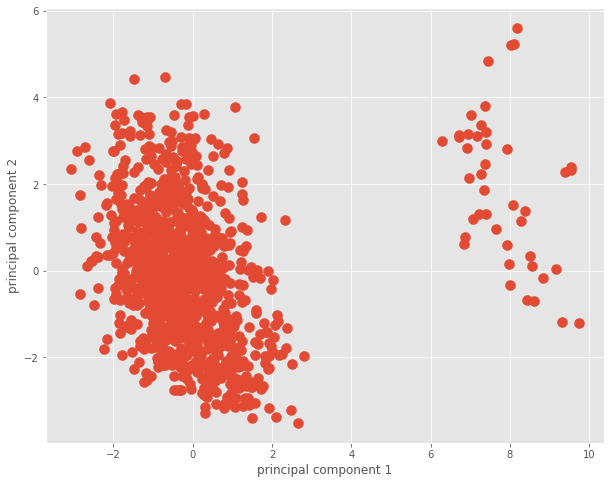

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pitch_df.iloc[:,0], pitch_df.iloc[:,1], s=100)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2');

In [13]:
# fig, ax = plt.subplots(4, 3, figsize=(10,8))

### K-Means

In [14]:
inertias = []
mapping = {}
K = range(1, 21)
 
for k in K:
    km = KMeans(n_clusters = k).fit(X_scaled)
    km.fit(X_scaled)
 
    inertias.append(km.inertia_)

    mapping[k] = km.inertia_

In [15]:
# inertia
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 21440.0
2 : 19182.231214662424
3 : 15907.292855402802
4 : 14454.463071455932
5 : 13482.37779491113
6 : 12943.201906434626
7 : 12450.806810714004
8 : 12039.258201909232
9 : 11750.060942604221
10 : 11406.351522801244
11 : 11189.806141892426
12 : 10929.352584926055
13 : 10702.577189314683
14 : 10555.916389724109
15 : 10314.474673236295
16 : 10115.72755520313
17 : 9927.064296610692
18 : 9913.832133156015
19 : 9727.788434757182
20 : 9587.462088344628


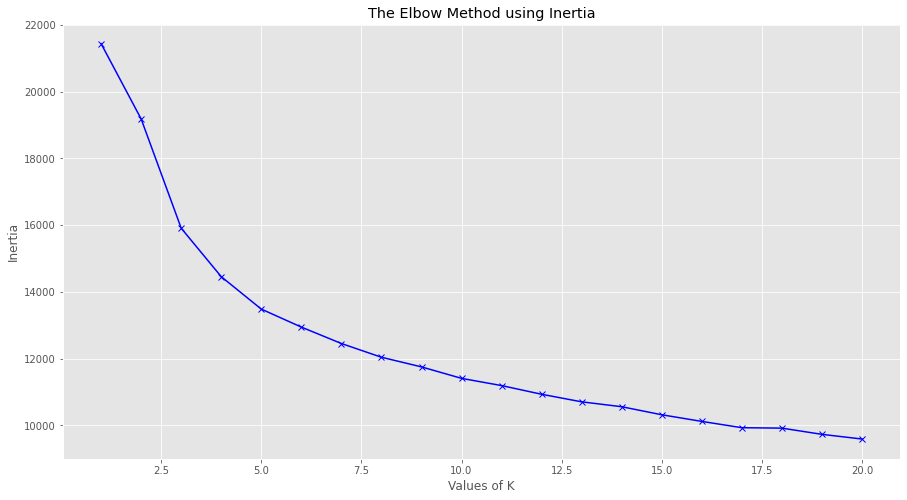

In [16]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
plt.figure(figsize = (15,8))

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia');

In [17]:
km = KMeans(n_clusters = 4,
            random_state = 0)

km.fit(pitch_df)
label = km.fit_predict(pitch_df)

print(label)

[0 2 2 ... 2 2 1]


In [18]:
print('label:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(pitch_df, label))

label: [0 2 2 ... 2 2 1]
Number of iterations: 50
Number of features: 20
Number of clusters: 4
Inertia: 14454.463071455933
Silhouette Score: 0.15028028220426923


In [19]:
centroids = km.cluster_centers_

print("Predicted clusters to points: ", label[:10], '\n')
print('Location of centroids:', '\n')

centroids_x = centroids[:, 0]
print('x:', centroids_x, '\n')

centroids_y = centroids[:, 1]
print('y:', centroids_y)

Predicted clusters to points:  [0 2 2 0 3 0 0 0 2 1] 

Location of centroids: 

x: [ 0.54498757 -0.58876347 -0.73305579  7.84231042] 

y: [-1.74805142  1.64969469  0.23327733  1.90304489]


In [20]:
#centroids_x = centroids[:5, 0:3:2]
#print('x', centroids_x)
#centroids_y = centroids[:5, 1:4:2]
#print('y', centroids_y, '\n')

In [21]:
X['label'] = label
pitch_df['label'] = label
pitch_df.head()

,age,solid_contact%,poor_weak%,ch%,4seam%,cu%,cb%,4seam_vb,sl_brk,sl%,...,ev_avg,4seam_brk,cb_brk,ch_brk,ch_spinrate,4seam_spinrate,4seam_velo,la_avg,cu_brk,label
0,1.429878,-3.087356,-0.719506,2.042114,-0.716140,0.142215,2.097339,1.397499,-1.271261,-0.394025,...,-0.193374,0.165738,-0.459827,0.391861,0.014720,-0.117835,0.054780,-0.122853,0.006265,0
1,0.064424,-0.654376,0.857198,0.118153,0.093268,-0.445635,1.283863,2.030625,-1.234262,0.237788,...,0.095479,0.499457,-0.247019,-0.203060,0.489288,-0.095240,-0.309711,-0.015293,0.032279,2
2,-0.853751,1.821725,-0.074936,-0.699313,-0.878928,1.610435,0.784313,2.386620,-0.874738,0.725133,...,0.211048,0.046601,-0.824025,0.427868,0.745682,-0.176743,0.077417,-0.212878,0.204125,2
3,1.060052,-3.150119,1.187005,1.567961,1.645008,2.010468,-0.529098,1.127169,-0.865391,0.377786,...,0.518510,-0.077798,-0.430645,1.450839,-0.174194,0.194225,-0.132594,-0.231193,-0.006138,0
4,9.536919,2.320517,0.004167,2.848243,4.108930,2.714320,-1.391794,0.943814,1.204951,0.865698,...,0.842181,-0.306596,0.434726,0.392214,0.246999,0.029742,-0.081546,-0.022165,0.092666,3


Cluster 0: likely all relievers, 0 ch %

Cluster 1: likely majority starters, high ch %

Cluster 2: Oldest group, likely majority starters, highest ch %

Cluster 3: youngest group, likely majority relievers, heavy fastball %

In [22]:
X.groupby(by = 'label').mean().T

label,0,1,2,3
age,30.088816,29.585859,28.153700,29.325581
solid_contact%,5.650658,6.169697,6.164516,4.900000
poor_weak%,4.491776,4.096970,4.113662,4.674419
ch%,15.842434,0.000000,11.942884,13.372093
4seam%,27.977961,37.929798,41.121822,0.000000
cu%,17.597368,6.644444,0.816129,15.265116
cb%,15.514145,10.006061,8.049336,10.134884
4seam_vb,-17.526974,-15.475758,-15.825806,0.000000
sl_brk,3.167105,5.827273,7.455408,6.053488
sl%,4.489474,23.368687,24.612524,14.762791


In [23]:
pitch_df.groupby(by = 'label').mean().T

label,0,1,2,3
age,0.544988,-0.588763,-0.733056,7.842310
solid_contact%,-1.748051,1.649695,0.233277,1.903045
poor_weak%,0.191884,-0.811922,0.370571,-2.159609
ch%,0.465538,2.108813,-0.898887,-1.985003
4seam%,-0.353101,0.119870,0.052019,1.306847
cu%,0.329718,-0.352854,-0.052637,-0.061159
cb%,-0.036993,-0.497134,0.211723,-0.044175
4seam_vb,-0.059532,0.155409,-0.039777,0.192770
sl_brk,-0.026953,-0.034111,0.039327,-0.134363
sl%,-0.022807,-0.101248,0.046904,0.052603


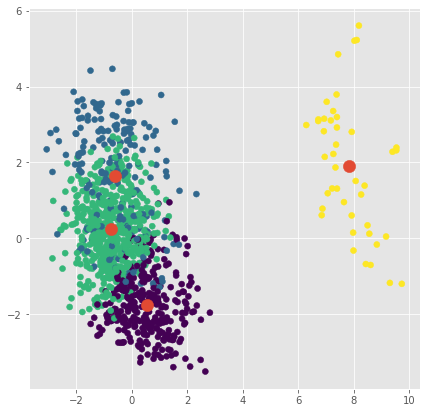

In [24]:
plt.figure(figsize=(7,7))

plt.scatter(pitch_df['age'], pitch_df['solid_contact%'], 
            c = pitch_df['label']);
plt.scatter(centroids[:, 0], 
            centroids[:, 1], 
            marker = 'o', s = 150);

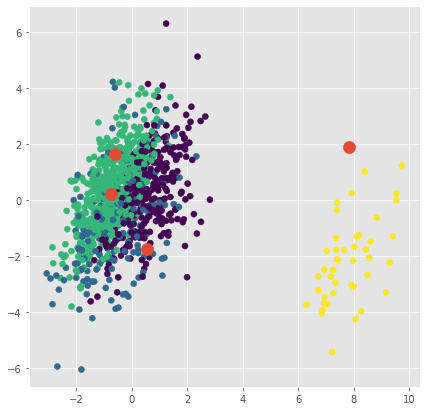

In [25]:
plt.figure(figsize=(7,7))

plt.scatter(pitch_df['age'], pitch_df['poor_weak%'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);
# plt.figure.savefig('Cluster1.png')

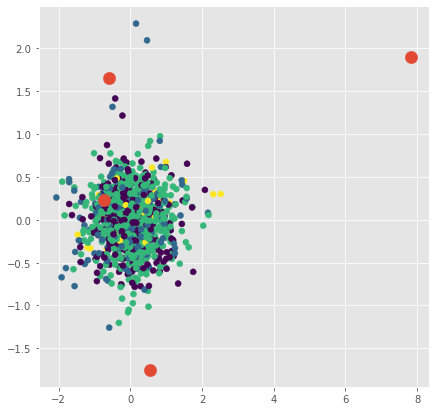

In [26]:
plt.figure(figsize=(7,7))

plt.scatter(pitch_df['4seam_brk'], pitch_df['4seam_spinrate'], 
            c = pitch_df['label']);
plt.scatter(centroids[:, 0], 
            centroids[:, 1], 
            marker = 'o', s = 150);

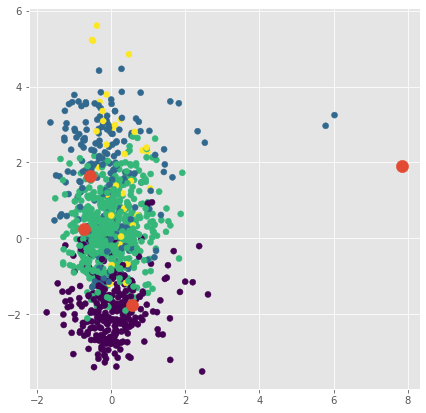

In [27]:
plt.figure(figsize=(7,7))

plt.scatter(pitch_df['ev_avg'], pitch_df['solid_contact%'], 
            c = pitch_df['label']);
plt.scatter(centroids[:, 0], 
            centroids[:, 1], 
            marker = 'o', s = 150);

In [28]:
#pitch_df = pitch_df.values
#plt.figure(figsize=(7,7))
#plt.scatter(pitch_df[label==0, 0], pitch_df[label==0, 1], c='red', label ='Cluster 1')
#plt.scatter(pitch_df[label==1, 0], pitch_df[label==1, 1], c='blue', label ='Cluster 2')
#plt.scatter(pitch_df[label==2, 0], pitch_df[label==2, 1], c='green', label ='Cluster 3')
#plt.scatter(pitch_df[label==3, 0], pitch_df[label==3, 1], c='cyan', label ='Cluster 4')
#plt.scatter(centroids[:, 0], centroids[:, 1], s=150, c='yellow', label = 'Centroids');